In [1]:
# 1. Importação das bibliotecas necessárias
# Bibliotecas gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from modelos import *


In [2]:
def carregar_e_preparar_dados(caminho_csv, coluna_target):
    """
    Função para carregar o dataset e separar em X (features) e y (rótulo).

    Args:
    - caminho_csv: caminho do arquivo CSV
    - coluna_target: nome da coluna que representa o rótulo

    Returns:
    - X_train, X_test, y_train, y_test: conjuntos de treino e teste
    """

    cols = ['NU_ANO','TP_FAIXA_ETARIA', 'TP_DEPENDENCIA_ADM_ESC', 
        'NPessoas', 'Escolaridade_Pai', 'Escolaridade_Mae', 'Renda', 'Computador',
        'Celular', 'Internet', f'{coluna_target}']

    #selecionando as colunas relevantes
    cols = ['NU_ANO','TP_FAIXA_ETARIA', 'TP_DEPENDENCIA_ADM_ESC', 
        'NPessoas', 'Escolaridade_Pai', 'Escolaridade_Mae', 'Renda', 'Computador',
        'Celular', 'Internet', f'{coluna_target}']

    df = pd.read_csv(caminho_csv, sep=',', usecols=cols)
    df = df[df['NU_ANO']> 2021]
    df = df.drop(columns=['NU_ANO'])

    oneHotdata = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
    oneHotdata = oneHotdata.fit_transform(df[['TP_DEPENDENCIA_ADM_ESC']])
    df = pd.concat([df, oneHotdata], axis=1)
    df = df.drop(columns=['TP_DEPENDENCIA_ADM_ESC'])
    novos_nomes = {
        'TP_DEPENDENCIA_ADM_ESC_1': 'Federal',
        'TP_DEPENDENCIA_ADM_ESC_2': 'Estadual',
        'TP_DEPENDENCIA_ADM_ESC_3': 'Municipal',
        'TP_DEPENDENCIA_ADM_ESC_4': 'Privada',
    }
    df.rename(columns=novos_nomes, inplace=True)

    # Balanceando o conjunto de dados para ter 50% de cada rótulo
    df_0 = df[df[coluna_target] == 0]
    df_1 = df[df[coluna_target] == 1]
    
    #FAZENDO BALANEAMENTO DOS DADOS
    min_size = min(len(df_0), len(df_1))
    print(min_size)
    df_0 = df_0.sample(n=min_size, random_state=42)
    df_1 = df_1.sample(n=min_size, random_state=42)
    
    # Concatenando os dois grupos balanceados
    df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
    df.dropna(inplace=True)

    # Separando variáveis independentes e dependente
    X = df.drop(columns=[coluna_target])
    y = df[coluna_target]#pd.get_dummies(df[coluna_target], prefix=coluna_target)


    # Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    #Normalização
    scaler = MinMaxScaler()
    X_train['TP_FAIXA_ETARIA'] = scaler.fit_transform(X_train[['TP_FAIXA_ETARIA']])
    X_test['TP_FAIXA_ETARIA'] = scaler.transform(X_test[['TP_FAIXA_ETARIA']])   #aqui não vai o fit, pois o teste não pode colar do treino
                    
    X_train['Renda'] = scaler.fit_transform(X_train[['Renda']])
    X_test['Renda'] = scaler.transform(X_test[['Renda']])   #aqui não vai o fit, pois o teste não pode colar do treino
                    
    X_train['NPessoas'] = scaler.fit_transform(X_train[['NPessoas']])
    X_test['NPessoas'] = scaler.transform(X_test[['NPessoas']])   #aqui não vai o fit, pois o teste não pode colar do treino
              
    X_train['Escolaridade_Mae'] = scaler.fit_transform(X_train[['Escolaridade_Mae']])
    X_test['Escolaridade_Mae'] = scaler.transform(X_test[['Escolaridade_Mae']])   #aqui não vai o fit, pois o teste não pode colar do treino

    X_train['Escolaridade_Pai'] = scaler.fit_transform(X_train[['Escolaridade_Pai']])
    X_test['Escolaridade_Pai'] = scaler.transform(X_test[['Escolaridade_Pai']])   #aqui não vai o fit, pois o teste não pode colar do treino


    return X_train, X_test, y_train, y_test, df

In [3]:
file = 'Data/enem_2011_2023.csv'  # Substitua pelo caminho do seu arquivo CSVASD

X_train, X_test, y_train, y_test, df = carregar_e_preparar_dados(file, 'Desempenho')
X_train

11043


,TP_FAIXA_ETARIA,NPessoas,Escolaridade_Pai,Escolaridade_Mae,Renda,Computador,Celular,Internet,Federal,Estadual,Municipal,Privada
6253,0.000000,0.105263,0.666667,0.666667,0.05,1,1,1,0.0,1.0,0.0,0.0
6241,0.058824,0.263158,0.833333,0.833333,0.40,1,1,1,0.0,0.0,0.0,1.0
17233,0.117647,0.210526,0.333333,0.666667,0.05,0,1,1,0.0,1.0,0.0,0.0
11562,0.058824,0.157895,0.166667,0.500000,0.05,0,1,1,0.0,1.0,0.0,0.0
1277,0.058824,0.157895,0.333333,0.500000,0.05,0,1,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0.117647,0.157895,0.166667,0.166667,0.05,0,1,1,0.0,1.0,0.0,0.0
21575,0.058824,0.210526,0.833333,1.000000,0.75,1,1,1,0.0,0.0,0.0,1.0
5390,0.117647,0.157895,0.166667,0.166667,0.05,0,1,0,0.0,1.0,0.0,0.0
860,0.117647,0.157895,0.166667,0.166667,0.05,0,1,1,0.0,1.0,0.0,0.0


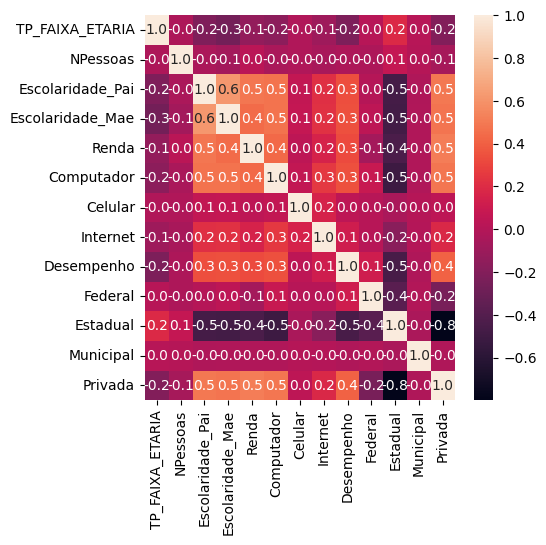

In [4]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), annot=True, fmt='.1f')
plt.show()

### PRIMEIRO VEJO AQUI, QUAL A PROFUNDIDADE IDEAL PARA NÃO OCORRER OVERFIT

max_depth tested:  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  

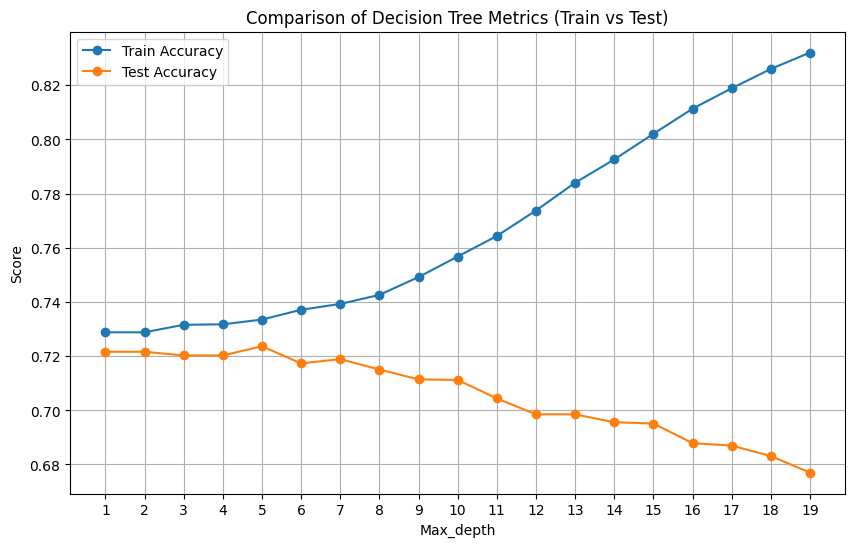

Best max_depth_tree: 5
Metrics for best max_depth: {'train_accuracy': 0.7334729454380802, 'test_accuracy': 0.7236306020823903, 'precision': 0.7238198196233422, 'recall': 0.7236306020823903, 'f1': 0.7235051374111936}


(5,
 {'train_accuracy': 0.7334729454380802,
  'test_accuracy': 0.7236306020823903,
  'precision': 0.7238198196233422,
  'recall': 0.7236306020823903,
  'f1': 0.7235051374111936})

In [5]:
best_depth_for_tree(X_train, X_test, y_train, y_test)

### APLICANDO  A ÁRVORE

Árvores de decisão nos ajudam a visualizar dados linearmente não separáveis

In [ ]:
modelo_arvore_decisao(X_train, X_test, y_train, y_test)

# SVM

In [ ]:
modelo_svm(X_train, X_test, y_train, y_test)

# REDES NEURAIS

Usamos o cálculo da dimensão VC para justificar a escolha da arquitetura da Rede Neural: 
    - Nº de Camadas
    - Nº de Neurônios
    

Cálculo do Nº de Neurônios:


In [ ]:
def num_neurons(n_examples, n_features):
    return int((n_examples - 10) / (10 * (n_features + 2) ))

In [ ]:
N = len(X_train)
n_variaveis = X_train.shape[1]
print(X_train.shape)

print('Nº máximo de neurônios:')
print(num_neurons(N, n_variaveis))

(11206, 12)
Nº máximo de neurônios:
79


In [ ]:
output_dim = len(np.unique(y_train))
output_dim

2

c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


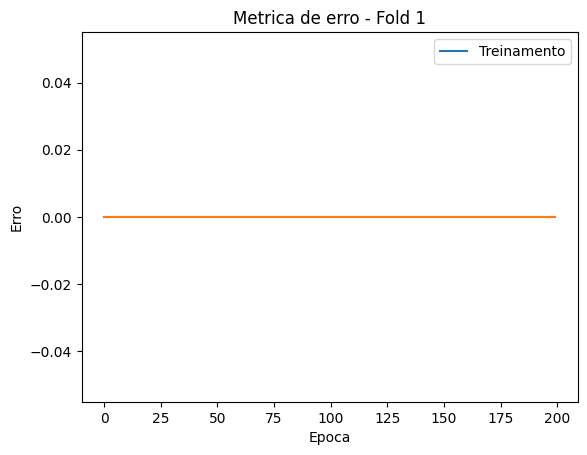

--> Acuracia (treino): 0.5015
--> Acuracia (validacao): 0.5013
--> E_val - E_in = 0.0000
--> acc_in - acc_val = 0.0001



KeyboardInterrupt: 

In [ ]:
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
n_neuronios = num_neurons(N, n_variaveis)
modelo_rede_neural(X_train, X_test, y_train, y_test, input_dim, output_dim, n_neuronios)